In [2]:
import time
import numpy as np
from scipy.stats import linregress
import Sweep_Interval
import IBM4_Lib
import csv 
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
from scipy.optimize import curve_fit


# Lab 5

2 + 4 wire 

In [ ]:
# Initialize IBM4 interface
the_dev = IBM4_Lib.Ser_Iface()  # find the first connected IBM4, open in DC mode by default
        
# Current source parameters (from previous lab)
rl = 10
rg = 56e3
r1 = 1 / (1/4.7 + 1/33)
G = 5 + (200e3/rg)
        
# Channel configuration for 2-wire and 4-wire measurements
output_ch = 'A0'        # Current source control voltage - for LED
input_ch_via = 'A2'     # Instrumentation amplifier output (for current measurement)
input_ch_2wire = 'A4'   # 2-wire voltage measurement across load
input_ch_4wire_high = 'D2'  # 4-wire high side voltage measurement
input_ch_4wire_low = 'A5'   # 4-wire low side voltage measurement (method 1 from Fig 4)
input_vout = 'A3' 


# For data & plot naming/saving - change for each measurement
device = 'Red LED with resistance 26.7kΩ'  
device_ = 'Red26.7k_fr'    
R = 0.4 # Responsivity of the device in A/V
R_TIA = 26.7e3  # 26.7 kΩ

# Measurement parameters
Nreads = 300
max_current_mA = 35
current_steps = 40
        
# Calculate voltage range needed for desired current
# Using calibration from previous lab: Iout = K * Vset
K_approx = 29.487  # Approximate mA/V from previous calibration
max_voltage = max_current_mA / K_approx
volts = np.linspace(0, max_voltage, current_steps)
        
print("Device Characterization: 2-Wire and 4-Wire Measurements")
print(f"Current Range: 0 to {max_current_mA} mA")
print(f"Analog Out: {output_ch}")
print(f"Output Voltage (Light): {input_vout}")
print(f"Analog In VIA: {input_ch_via}")
print(f"2-Wire Voltage: {input_ch_2wire}")
print(f"4-Wire High: {input_ch_4wire_high}")
print(f"4-Wire Low: {input_ch_4wire_low}")
        
# -----------------------------
# DATA ACQUISITION
# -----------------------------
results = []
start = time.time()
        
# Initialize current source
the_dev.WriteVoltage(output_ch, 0.0)
time.sleep(0.5)

print("Connect shorting wire before attaching laser!")
        
print("\nStarting measurements...")
for v in volts:
    the_dev.WriteVoltage(output_ch, v)
    time.sleep(0.01)  # Short settling time
            
    # Read all measurement channels
    via = the_dev.ReadAverageVoltage(input_ch_via, Nreads)
    vout = the_dev.ReadAverageVoltage(input_vout, Nreads)
    v_2wire = the_dev.ReadAverageVoltage(input_ch_2wire, Nreads)
    v_4wire_high = the_dev.ReadAverageVoltage(input_ch_4wire_high, Nreads)
    v_4wire_low = the_dev.ReadAverageVoltage(input_ch_4wire_low, Nreads)
            
    # Calculate 4-wire voltage (difference between high and low)
    v_4wire = v_4wire_high - v_4wire_low
            
    # Calculate current from instrumentation amplifier
    current_mA = (via / (G * r1)) * 1000.0
        
    print(f"Vset={v:.3f}V | I={current_mA:.2f}mA | V_2w={v_2wire:.4f}V | V_4w={v_4wire:.4f}V")
            
    results.append({"Vset": v, "Current_mA": current_mA, "Output_Voltage": vout, "V_2wire": v_2wire, "V_4wire": v_4wire, "V_4wire_high": v_4wire_high, "V_4wire_low": v_4wire_low, "VIA": via})
        
end = time.time()
deltaT = end - start
readsTot = len(volts) * Nreads * 5  # 5 measurement channels
SR = readsTot / deltaT if deltaT > 0 else float('nan')
print(f"{readsTot} measurements in {deltaT:.3f}s => SR = {SR:.2f} Hz")
        
# -----------------------------
# DATA PROCESSING
# -----------------------------
df = pd.DataFrame(results)
        
# Calculate resistances for both methods
df["R_2wire"] = df["V_2wire"] / (df["Current_mA"] / 1000.0)  # R = V/I
df["R_4wire"] = df["V_4wire"] / (df["Current_mA"] / 1000.0)  # R = V/I

# Calculate the current
df["Iph_A"] = df["Output_Voltage"] / R_TIA

# Calculate the optical power
df['P_opt_W'] = df['Iph_A'] / R
df['P_opt_uW'] = df['P_opt_W'] * 1e6

# Remove invalid measurements (zero current)
df_valid = df[df["Current_mA"] > 0.1].copy()
        
if len(df_valid) > 0:
    # Calculate average resistances
    avg_R_2wire = df_valid["R_2wire"].mean()
    avg_R_4wire = df_valid["R_4wire"].mean()
            
    print(f"\nAverage 2-wire resistance: {avg_R_2wire:.4f} Ω")
    print(f"Average 4-wire resistance: {avg_R_4wire:.4f} Ω")
    print(f"Resistance difference: {abs(avg_R_2wire - avg_R_4wire):.4f} Ω")

# -----------------------------
# LOGARITHMIC FITTING
# -----------------------------
def logarithmic_fit(x, a, b):
    """Logarithmic function: y = a * log(x) + b"""
    return a * np.log(x) + b

def fit_and_plot_logarithmic(df, measurement_type):
    """Perform logarithmic fitting and return fit parameters"""
    # Filter out zero and negative values for logarithmic fitting
    valid_data = df[(df["Current_mA"] > 0.1) & (df[f"V_{measurement_type}"] > 0)].copy()
    
    if len(valid_data) < 3:
        print(f"Not enough valid data points for {measurement_type} logarithmic fitting")
        return None, None, None
    
    x_data = valid_data["Current_mA"].values
    y_data = valid_data[f"V_{measurement_type}"].values
    
    try:
        # Perform logarithmic fitting
        popt, pcov = curve_fit(logarithmic_fit, x_data, y_data, maxfev=5000)
        
        # Calculate R-squared
        residuals = y_data - logarithmic_fit(x_data, *popt)
        ss_res = np.sum(residuals**2)
        ss_tot = np.sum((y_data - np.mean(y_data))**2)
        r_squared = 1 - (ss_res / ss_tot) if ss_tot != 0 else 0
        
        return popt, pcov, r_squared
        
    except Exception as e:
        print(f"Logarithmic fitting failed for {measurement_type}: {e}")
        return None, None, None

# Perform logarithmic fitting for both measurement types
print("\n" + "="*50)
print("LOGARITHMIC FITTING ANALYSIS")
print("="*50)

fit_results = {}

for measurement_type in ['2wire', '4wire']:
    popt, pcov, r_squared = fit_and_plot_logarithmic(df, measurement_type)
    
    if popt is not None:
        a, b = popt
        print(f"\n{measurement_type.upper()} Logarithmic Fit:")
        print(f"  Equation: V = {a:.4f} * log(I) + {b:.4f}")
        print(f"  R-squared: {r_squared:.6f}")
        print(f"  Parameters: a = {a:.4f} ± {np.sqrt(pcov[0,0]):.4f}, b = {b:.4f} ± {np.sqrt(pcov[1,1]):.4f}")
        
        fit_results[measurement_type] = {
            'params': popt,
            'covariance': pcov,
            'r_squared': r_squared
        }
    else:
        fit_results[measurement_type] = None

# -----------------------------
# PLOTTING
# -----------------------------
plt.figure(figsize=(12, 8))

# Plot 2-wire IV curve
plt.plot(df["Current_mA"], df["V_2wire"], 'r--', label='2-Wire Measurement', markersize=4, linewidth=1)

# Plot 4-wire IV curve
plt.plot(df["Current_mA"], df["V_4wire"], 'g--', label='4-Wire Measurement', markersize=4, linewidth=1)

# Plot V_light
plt.plot(df["Current_mA"], df["Output_Voltage"], 'b-', label='Output Voltage', markersize=4, linewidth=1)

Fit, Off = np.polyfit(df["Current_mA"], df["Output_Voltage"], 1)
x_vset = np.linspace(df["Current_mA"].min(), df["Current_mA"].max(), 200)
plt.plot(x_vset, Fit * x_vset + Off, 'c--', linewidth=2, label=f'Linear Fit: K = {Fit:.3f}·I + {Off:.3f}')

# Plot logarithmic fits if available
current_fit = np.linspace(df_valid["Current_mA"].min(), df_valid["Current_mA"].max(), 100)

if '2wire' in fit_results and fit_results['2wire'] is not None:
    a, b = fit_results['2wire']['params']
    fit_2wire = logarithmic_fit(current_fit, a, b)
    plt.plot(current_fit, fit_2wire, 'm--', 
             label=f'2-Wire Log Fit: V = {a:.3f}·log(I) + {b:.3f}\n(R² = {fit_results["2wire"]["r_squared"]:.4f})',
             linewidth=2)

if '4wire' in fit_results and fit_results['4wire'] is not None:
    a, b = fit_results['4wire']['params']
    fit_4wire = logarithmic_fit(current_fit, a, b)
    plt.plot(current_fit, fit_4wire, 'k--', 
             label=f'4-Wire Log Fit: V = {a:.3f}·log(I) + {b:.3f}\n(R² = {fit_results["4wire"]["r_squared"]:.4f})',
             linewidth=2)

plt.xlabel('Current (mA)')
plt.ylabel('Voltage (V)')
plt.title(f'Device Characterization: 2-Wire vs 4-Wire IV Curves with Logarithmic Fitting for {device}')
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

iv_plot_filename = f"Device_IV_Characterization_with_Log_Fit_{device_}.png"
plt.savefig(iv_plot_filename, dpi=300)
print(f"IV characterization plot with logarithmic fit saved as '{iv_plot_filename}'")
plt.show()

# -----------------------------
# OPTICAL POWER PLOTS
# -----------------------------

# Optical Power vs Current
plt.figure(figsize=(8,6))
plt.plot(df['Current_mA'], df['P_opt_uW'], '.-', color="orange", label="Optical Power")
plt.xlabel('LED Drive Current (mA)')
plt.ylabel('Optical Power P_opt (µW)')
plt.title(f'Optical Power vs LED Drive Current for {device}')
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.savefig(f"OpticalPower_vs_LEDcurrent_{device_}.png", dpi=300)
plt.close()

# ------------------ Combined IV + Optical Power Plot ------------------
fig, ax1 = plt.subplots(figsize=(12,8))
ax1.plot(df["Current_mA"], df["V_2wire"], 'r--', label='2-Wire Measurement', linewidth=1)
ax1.plot(df["Current_mA"], df["V_4wire"], 'g--', label='4-Wire Measurement', linewidth=1)

# Avoid log(0) by filtering positive currents only
df_nonzero = df[df["Current_mA"] > 0].copy()
log_I = np.log(df_nonzero["Current_mA"])

# Log-fit for 2-wire
log_fit_2, log_off_2 = np.polyfit(log_I, df_nonzero["V_2wire"], 1)
y2 = log_fit_2 * np.log(x_vset) + log_off_2
ax1.plot(x_vset, y2, 'r-', linewidth=1.5,
         label=f"2-Wire Log Fit: V = {log_fit_2:.3f}·ln(I) + {log_off_2:.3f}")

# Log-fit for 4-wire
log_fit_4, log_off_4 = np.polyfit(log_I, df_nonzero["V_4wire"], 1)
y4 = log_fit_4 * np.log(x_vset) + log_off_4
ax1.plot(x_vset, y4, 'g-', linewidth=1.5,
         label=f"4-Wire Log Fit: V = {log_fit_4:.3f}·ln(I) + {log_off_4:.3f}")

# Optical Power on Secondary Axis
ax2 = ax1.twinx()
ax2.plot(df["Current_mA"], df["P_opt_uW"], 'yo', linewidth=1, label='Optical Power (µW)')
ax2.set_ylabel('Optical Power (µW)', color='y')
ax2.tick_params(axis='y', labelcolor='y')

ax1.set_xlabel('Current (mA)')
ax1.set_ylabel('Voltage (V)')
plt.title(f'Device Characterization: IV Curves and Optical Power for {device}')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig(f"IV_LI_Characteristics_{device_}.png", dpi=300)
plt.close()


# -----------------------------
# PLOTTING - CURRENT vs VOLTAGE (Alternative view)
# -----------------------------
plt.figure(figsize=(12, 8))

# Plot 2-wire measurement (Current vs Voltage)
plt.plot(df["V_2wire"], df["Current_mA"], 'ro-', label='2-Wire Measurement', markersize=4, linewidth=1)

# Plot 4-wire measurement (Current vs Voltage)
plt.plot(df["V_4wire"], df["Current_mA"], 'bs-', label='4-Wire Measurement', markersize=4, linewidth=1)

plt.xlabel('Voltage (V)')
plt.ylabel('Current (mA)')
plt.title(f"Current vs Voltage Characteristics: 2-Wire vs 4-Wire Measurements for {device}")
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

current_vs_voltage_plot_filename = f"Current_vs_Voltage_Characteristics_{device_}.png"
plt.savefig(current_vs_voltage_plot_filename, dpi=300)
print(f"Current vs Voltage plot saved as '{current_vs_voltage_plot_filename}'")
plt.show()


# Plot resistance comparison
if len(df_valid) > 0:
    plt.figure(figsize=(10, 6))
    plt.plot(df_valid["Current_mA"], df_valid["R_2wire"], 'ro-', label='2-Wire Resistance', markersize=4, linewidth=1)
    plt.plot(df_valid["Current_mA"], df_valid["R_4wire"], 'bs-', label='4-Wire Resistance', markersize=4, linewidth=1)
            
    plt.xlabel('Current (mA)')
    plt.ylabel('Resistance (Ω)')
    plt.title(f'Device Resistance vs Current for {device}')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.legend()
    plt.tight_layout()
            
    resistance_plot_filename = f"Device_Resistance_Characterization for {device_}.png"
    plt.savefig(resistance_plot_filename, dpi=300)
    print(f"Resistance characterization plot saved as '{resistance_plot_filename}'")
    plt.show()


# -----------------------------
# SAVE DATA TO CSV
# -----------------------------
csv_filename = f'Device_Characterization_Data_{device_}.csv'
df.to_csv(csv_filename, index=False)
print(f"Data saved to '{csv_filename}' ({len(df)} points)")

# Save fitting results
if fit_results['2wire'] is not None or fit_results['4wire'] is not None:
    fit_filename = f"Logarithmic_Fitting_Results'{device}'.txt"
    with open(fit_filename, 'w') as f:
        f.write("Logarithmic Fitting Results for IV Curves\n")
        f.write("========================================\n\n")
        
        for measurement_type in ['2wire', '4wire']:
            if fit_results[measurement_type] is not None:
                a, b = fit_results[measurement_type]['params']
                r_squared = fit_results[measurement_type]['r_squared']
                f.write(f"{measurement_type.upper()} Measurement:\n")
                f.write(f"  Equation: V = {a:.6f} * log(I) + {b:.6f}\n")
                f.write(f"  R-squared: {r_squared:.6f}\n")
                f.write(f"  Parameter uncertainties: a ± {np.sqrt(fit_results[measurement_type]['covariance'][0,0]):.6f}, "
                       f"b ± {np.sqrt(fit_results[measurement_type]['covariance'][1,1]):.6f}\n\n")
    
    print(f"Fitting results saved to '{fit_filename}'")



# -----------------------------
# CLEANUP
# -----------------------------
# Turn off current source
the_dev.WriteVoltage(output_ch, 0.0)
time.sleep(0.1)
del the_dev

current

In [8]:

# -----------------------------
# Filenames
# -----------------------------
photodiode_csv = {
    'amber': "Device_Characterization_Data_Amber26.7k_fr.csv",
    'blue': "Device_Characterization_Data_Blue26.7k_fr.csv",
    'green': "Device_Characterization_Data_Green26.7k_fr.csv",
    'red': "Device_Characterization_Data_Red26.7k_fr.csv"
}

current_csv = "/Users/mathildedeclercq/Desktop/College/PY3108/Lab 2/CurrentSource_Characterization_Data.csv"

output_csv = {
    'amber': "Device_Characterization_Data_Amber26.7k_fr_current.csv",
    'blue': "Device_Characterization_Data_Blue26.7k_fr_current.csv",
    'green': "Device_Characterization_Data_Green26.7k_fr_current.csv",
    'red': "Device_Characterization_Data_Red26.7k_fr_current.csv"
}

R_TIA = 26.7e3  # 26.7 kΩ

# -----------------------------
# Load current source characterization data
# -----------------------------
df_current = pd.read_csv(current_csv)

vset_array = df_current["Vset"].values
iout_array = df_current["Iout_mA"].values

# Linear interpolation function
def vset_to_current(vset):
    return np.interp(vset, vset_array, iout_array)

# -----------------------------
# Process each LED color
# -----------------------------
for color, fname in photodiode_csv.items():
    df_photo = pd.read_csv(fname)

    if "Vset" not in df_photo.columns:
        raise ValueError(f"'Vset' column not found in {fname}")

    # Apply interpolation
    df_photo["Illumination_mA"] = df_photo["Vset"].apply(vset_to_current)

    df_photo["Iph_A"] = df_photo["Output_Voltage"] / R_TIA


    # Optional: remove the old voltage column
    # df_photo.drop(columns=["Vset"], inplace=True)

    # Save the new CSV
    out_name = output_csv[color]
    df_photo.to_csv(out_name, index=False)
    print(f"Processed CSV saved as '{out_name}'")
    print(df_photo.head(), "\n")




Processed CSV saved as 'Device_Characterization_Data_Amber26.7k_fr_current.csv'
       Vset  Current_mA  Output_Voltage  V_2wire   V_4wire  V_4wire_high  \
0  0.000000    0.492741        0.297348  1.37248  1.360075       1.37115   
1  0.030435    0.497463        0.297139  1.37448  1.362189       1.37327   
2  0.060870    0.509189        0.297402  1.37829  1.366054       1.37714   
3  0.091305    0.535227        0.297461  1.82937  1.847120       1.86167   
4  0.121740    2.995716        0.302594  1.87997  1.856894       1.87261   

   V_4wire_low       VIA      R_2wire      R_4wire  Illumination_mA     Iph_A  
0     0.011075  0.017376  2785.398728  2760.223024         1.132230  0.000011  
1     0.011081  0.017542  2762.981803  2738.275421         1.144654  0.000011  
2     0.011086  0.017956  2706.835867  2682.805675         1.245121  0.000011  
3     0.014550  0.018874  3417.933125  3451.096252         1.504062  0.000011  
4     0.015716  0.105639   627.552835   619.849901         3.19

optical power

In [9]:
illumination_csv = {

    'amber': "Device_Characterization_Data_Amber26.7k_fr_current.csv",
    'blue': "Device_Characterization_Data_Blue26.7k_fr_current.csv",
    'green': "Device_Characterization_Data_Green26.7k_fr_current.csv",
    'red': "Device_Characterization_Data_Red26.7k_fr_current.csv"

}
#  Photodiode responsivity for each LED (A/W)
responsivities = {
    'amber': 0.41,
    'blue': 0.19,
    'green': 0.33,
    'red': 0.42,

}

output_csv = {
    'amber': "Device_Characterization_Data_Amber26.7k_fr_current_power.csv",
    'blue': "Device_Characterization_Data_Blue26.7k_fr_current_power.csv",
    'green': "Device_Characterization_Data_Green26.7k_fr_current_power.csv",
    'red': "Device_Characterization_Data_Red26.7k_fr_current_power.csv"
}

# -----------------------------
# Read CSVs and compute optical power
# -----------------------------
dataframes = {}

for color, fname in illumination_csv.items():
    df = pd.read_csv(fname)
    R = responsivities[color]
    # Compute optical power in watts


    # Compute optical power in watts and microwatts
    df['P_opt_W'] = df['Iph_A'] / R
    df['P_opt_uW'] = df['P_opt_W'] * 1e6

    dataframes[color] = df
    out_name = output_csv[color]
    df.to_csv(out_name, index=False)
    print(f"Processed CSV saved as '{out_name}'")
    print(df.head(), "\n")





Processed CSV saved as 'Device_Characterization_Data_Amber26.7k_fr_current_power.csv'
       Vset  Current_mA  Output_Voltage  V_2wire   V_4wire  V_4wire_high  \
0  0.000000    0.492741        0.297348  1.37248  1.360075       1.37115   
1  0.030435    0.497463        0.297139  1.37448  1.362189       1.37327   
2  0.060870    0.509189        0.297402  1.37829  1.366054       1.37714   
3  0.091305    0.535227        0.297461  1.82937  1.847120       1.86167   
4  0.121740    2.995716        0.302594  1.87997  1.856894       1.87261   

   V_4wire_low       VIA      R_2wire      R_4wire  Illumination_mA     Iph_A  \
0     0.011075  0.017376  2785.398728  2760.223024         1.132230  0.000011   
1     0.011081  0.017542  2762.981803  2738.275421         1.144654  0.000011   
2     0.011086  0.017956  2706.835867  2682.805675         1.245121  0.000011   
3     0.014550  0.018874  3417.933125  3451.096252         1.504062  0.000011   
4     0.015716  0.105639   627.552835   619.849901  

In [15]:
# Updated script with log-scale fits for 2-wire and 4-wire slopes

# -----------------------------
# User settings
# -----------------------------
csv_files = {
    'amber': "Device_Characterization_Data_Amber26.7k_fr_current_power.csv",
    'blue': "Device_Characterization_Data_Blue26.7k_fr_current_power.csv",
    'green': "Device_Characterization_Data_Green26.7k_fr_current_power.csv",
    'red': "Device_Characterization_Data_Red26.7k_fr_current_power.csv"
}

responsivities = {
    'amber': 0.41,
    'blue': 0.19,
    'green': 0.33,
    'red': 0.42,
}

color_map = {
    "red": "red",
    "blue": "blue",
    "green": "green",
    "amber": "#FFBF00"
}

device = {
    "red": "Red LED with resistance 26.7kΩ ", 
    "amber": "Amber LED with resistance 26.7kΩ ", 
    "blue": "Blue LED with resistance 26.7kΩ ", 
    "green": "Green LED with resistance 26.7kΩ "
}

device_ = {
    "red": "Red26.7k_fr",
    "blue": "Blue26.7k_fr",
    "green": "Green26.7k_fr",
    "amber": "Amber26.7k_fr"
}

for color, filepath in csv_files.items():
    df = pd.read_csv(filepath)

    if "P_opt_uW" not in df.columns:
        G = 1e5
        R_lambda = responsivities[color]
        df["P_W"] = df["Output_Voltage"] / (G * R_lambda)
        df["P_opt_uW"] = df["P_W"] * 1e6

    plt.figure(figsize=(8,6))
    plot_color = color_map.get(color, "black")
    plt.plot(df['Current_mA'], df['P_opt_uW'], '.-', color=plot_color, label=f"{color.capitalize()} LED")
    plt.xlabel('LED Drive Current (mA)')
    plt.ylabel('Optical Power P_opt (µW)')
    plt.title(f'Optical Power vs LED Drive Current ({color.capitalize()} LED)')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"OpticalPower_vs_LEDcurrent_{color}.png", dpi=300)
    plt.close()

    # ------------------ Combined IV + Optical Power Plot ------------------
    fig, ax1 = plt.subplots(figsize=(12,8))
    ax1.plot(df["Current_mA"], df["V_2wire"], 'r--', label='2-Wire Measurement', linewidth=1)
    ax1.plot(df["Current_mA"], df["V_4wire"], 'g--', label='4-Wire Measurement', linewidth=1)


    # --------------- Log Fits for 2-wire and 4-wire ----------------
    # Avoid log(0) by filtering positive currents only
    df_nonzero = df[df["Current_mA"] > 0].copy()

    # Compute log currents
    log_I = np.log(df_nonzero["Current_mA"])

    # Log-fit for 2-wire
    log_fit_2, log_off_2 = np.polyfit(log_I, df_nonzero["V_2wire"], 1)
    y2 = log_fit_2 * np.log(x_vset) + log_off_2
    ax1.plot(x_vset, y2, 'r-', linewidth=1.5,
             label=f"2-Wire Log Fit: V = {log_fit_2:.3f}·ln(I) + {log_off_2:.3f}")

    # Log-fit for 4-wire
    log_fit_4, log_off_4 = np.polyfit(log_I, df_nonzero["V_4wire"], 1)
    y4 = log_fit_4 * np.log(x_vset) + log_off_4
    ax1.plot(x_vset, y4, 'g-', linewidth=1.5,
             label=f"4-Wire Log Fit: V = {log_fit_4:.3f}·ln(I) + {log_off_4:.3f}")

    # ------------------ Optical Power on Secondary Axis ------------------
    ax2 = ax1.twinx()
    ax2.plot(df["Current_mA"], df["P_opt_uW"], 'yo', linewidth=1, label='Optical Power (µW)')
    ax2.set_ylabel('Optical Power (µW)', color='y')
    ax2.tick_params(axis='y', labelcolor='y')

    ax1.set_xlabel('Current (mA)')
    ax1.set_ylabel('Voltage (V)')
    plt.title(f'Device Characterization: IV Curves and Optical Power for {device[color]}')

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.savefig(f"IV_LI_Characteristics_{color}.png", dpi=300)
    plt.close()


# Laser #

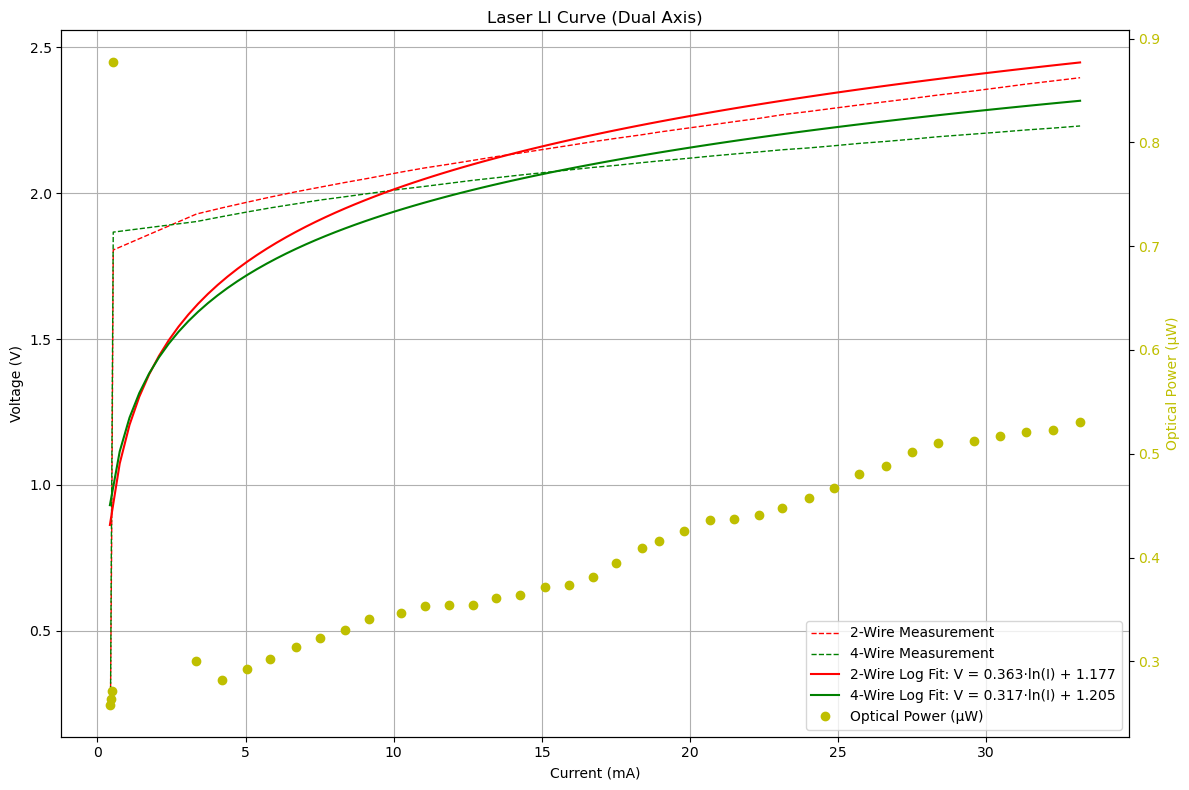

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# --- Load your CSV file ---
df = pd.read_csv("Device_Characterization_Data_Laser26.7k_fr.csv")

# --- Constants ---
G = 1e5          # Transimpedance gain in V/A
R_lambda = 0.40  # Photodiode responsivity in A/W at laser wavelength
T_path = 1.0     # Transmission factor
f_capture = 1.0  # Fraction of beam captured

# --- Compute optical power ---
Vpd = df["Output_Voltage"]
df["P_W"] = Vpd / (G * R_lambda * T_path * f_capture)
df["P_uW"] = df["P_W"] * 1e6

# --- Generate x_vset for fitting if not available ---
x_vset = np.linspace(df["Current_mA"].min(), df["Current_mA"].max(), 100)

# --- Plot with dual y-axes ---
fig, ax1 = plt.subplots(figsize=(12, 8))

# Left y-axis: IV curves
ax1.set_xlabel("Current (mA)")
ax1.set_ylabel("Voltage (V)")
line_2w, = ax1.plot(df["Current_mA"], df["V_2wire"], 'r--', label='2-Wire Measurement', linewidth=1)
line_4w, = ax1.plot(df["Current_mA"], df["V_4wire"], 'g--', label='4-Wire Measurement', linewidth=1)
ax1.tick_params(axis="y")

# --- Log fits for 2-wire and 4-wire ---
df_nonzero = df[df["Current_mA"] > 0].copy()
log_I = np.log(df_nonzero["Current_mA"])

# Log-fit for 2-wire
log_fit_2, log_off_2 = np.polyfit(log_I, df_nonzero["V_2wire"], 1)
y2 = log_fit_2 * np.log(x_vset) + log_off_2
line_y2, = ax1.plot(x_vset, y2, 'r-', linewidth=1.5,
         label=f"2-Wire Log Fit: V = {log_fit_2:.3f}·ln(I) + {log_off_2:.3f}")

# Log-fit for 4-wire
log_fit_4, log_off_4 = np.polyfit(log_I, df_nonzero["V_4wire"], 1)
y4 = log_fit_4 * np.log(x_vset) + log_off_4
line_y4, = ax1.plot(x_vset, y4, 'g-', linewidth=1.5,
         label=f"4-Wire Log Fit: V = {log_fit_4:.3f}·ln(I) + {log_off_4:.3f}")

# Right y-axis: optical power
ax2 = ax1.twinx()
line_opt, = ax2.plot(df["Current_mA"], df["P_uW"], 'yo', linewidth=1, label='Optical Power (µW)')
ax2.set_ylabel('Optical Power (µW)', color='y')
ax2.tick_params(axis='y', labelcolor='y')

plt.title("Laser LI Curve (Dual Axis)")
ax1.grid(True)

# Combine legend entries
lines = [line_2w, line_4w, line_y2, line_y4, line_opt]
labels = [ln.get_label() for ln in lines]

# Function to place legend where it doesn't overlap any plotted marker
def place_legend_avoiding_points(fig, ax_main, lines, labels):
    candidate_locs = ['upper right','upper left','lower left','lower right',
                      'center left','center right','upper center','lower center','center']
    # remove any existing legend
    if ax_main.get_legend() is not None:
        ax_main.get_legend().remove()
    for loc in candidate_locs:
        leg = ax_main.legend(lines, labels, loc=loc)
        fig.canvas.draw()
        bbox = leg.get_window_extent()
        conflict = False
        for ln in lines:
            ax_ln = ln.axes
            # get plotted data (may be sparse if line used as fit), check in display coords
            try:
                data = ln.get_xydata()
            except Exception:
                continue
            disp = ax_ln.transData.transform(data)
            inside = (disp[:,0] >= bbox.x0) & (disp[:,0] <= bbox.x1) & (disp[:,1] >= bbox.y0) & (disp[:,1] <= bbox.y1)
            if np.any(inside):
                conflict = True
                break
        if not conflict:
            return leg  # good location found
        leg.remove()
    # if all standard locations conflict, place legend outside on the right
    leg = ax_main.legend(lines, labels, bbox_to_anchor=(1.02, 1), loc='upper left')
    fig.canvas.draw()
    return leg

# Place legend
place_legend_avoiding_points(fig, ax1, lines, labels)

fig.tight_layout()
plt.savefig(f"IV_LI_Characteristics_Laser.png", dpi=300)

plt.show()


Resistance characterization plot saved as 'Device_Resistance_Characterization_amber.png'


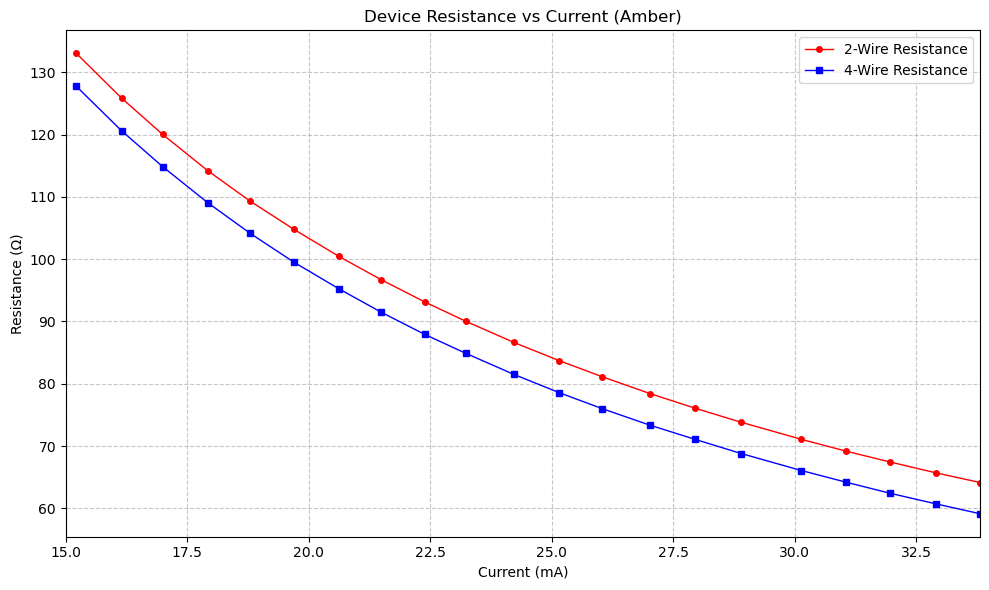

Resistance characterization plot saved as 'Device_Resistance_Characterization_blue.png'


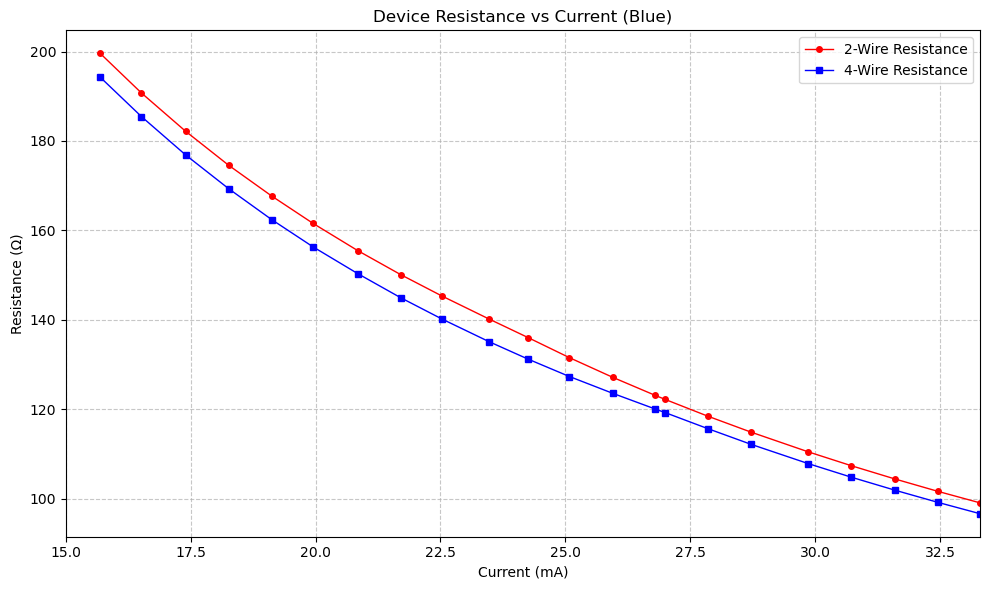

Resistance characterization plot saved as 'Device_Resistance_Characterization_green.png'


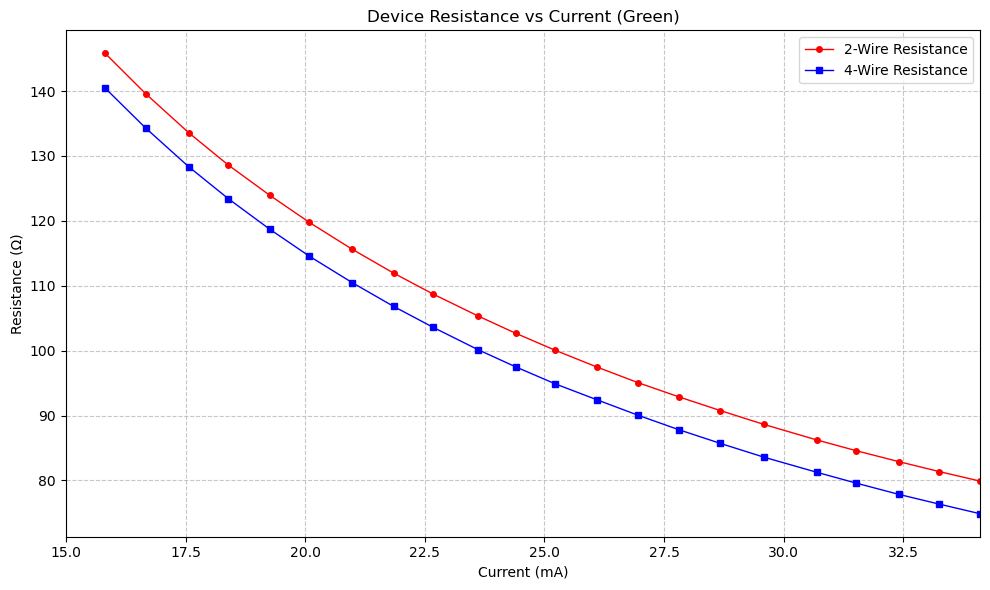

Resistance characterization plot saved as 'Device_Resistance_Characterization_red.png'


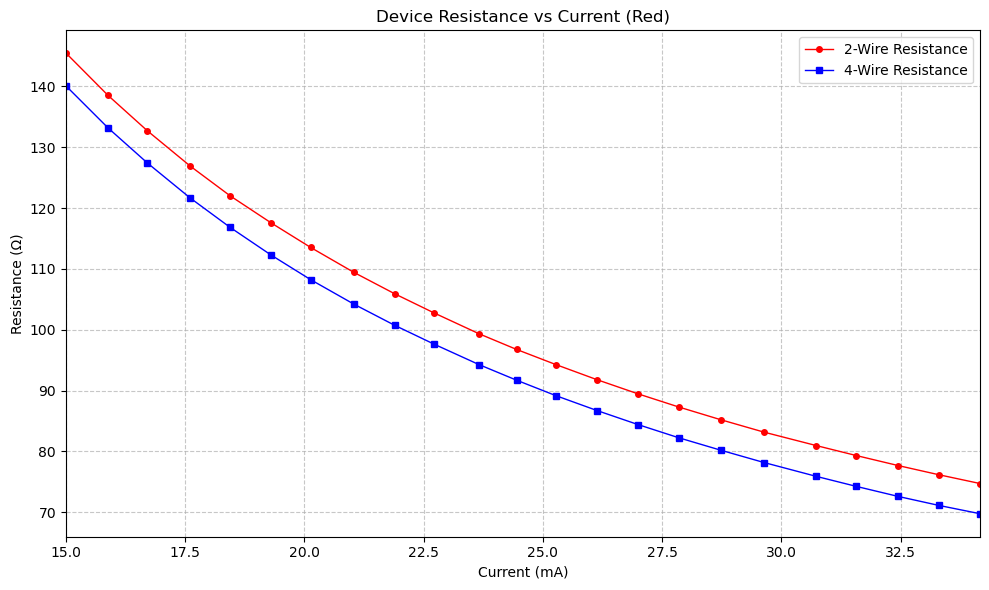

Resistance characterization plot saved as 'Device_Resistance_Characterization_laser.png'


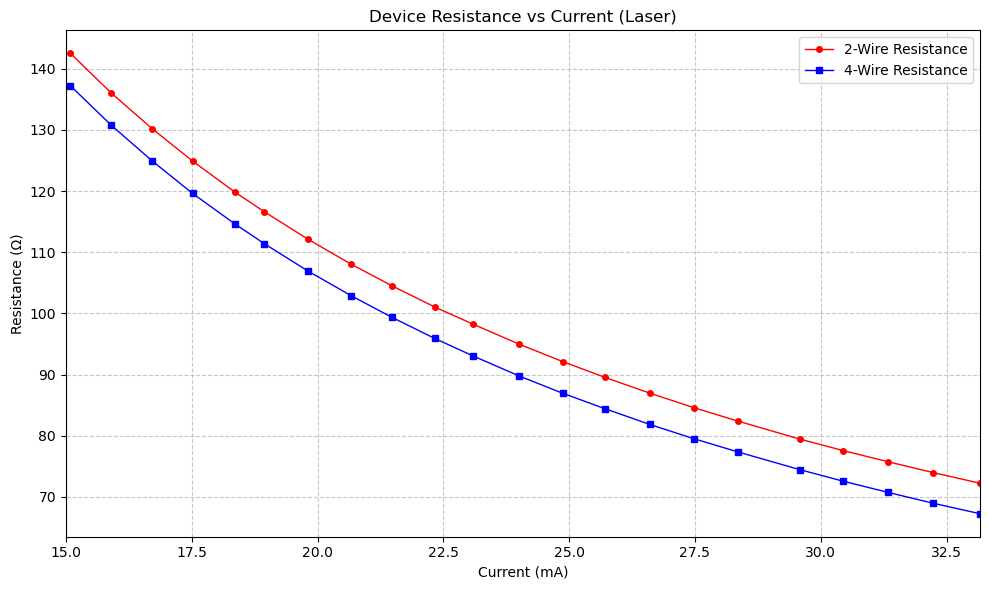

In [3]:
csv_files = {
    'amber': "Device_Characterization_Data_Amber26.7k_fr_current_power.csv",
    'blue': "Device_Characterization_Data_Blue26.7k_fr_current_power.csv",
    'green': "Device_Characterization_Data_Green26.7k_fr_current_power.csv",
    'red': "Device_Characterization_Data_Red26.7k_fr_current_power.csv",
    'laser': "Device_Characterization_Data_Laser26.7k_fr.csv"
}


for color, filepath in csv_files.items():
    df = pd.read_csv(filepath)
    
    # Filter data for current >= 15 mA
    df_valid = df[df["Current_mA"] >= 15].copy()
    
    if len(df_valid) > 0:
        # Calculate resistances
        df_valid["R_2wire"] = df_valid["V_2wire"] / (df_valid["Current_mA"] / 1000.0)
        df_valid["R_4wire"] = df_valid["V_4wire"] / (df_valid["Current_mA"] / 1000.0)
        
        plt.figure(figsize=(10, 6))
        plt.plot(df_valid["Current_mA"], df_valid["R_2wire"], 'ro-', label='2-Wire Resistance', markersize=4, linewidth=1)
        plt.plot(df_valid["Current_mA"], df_valid["R_4wire"], 'bs-', label='4-Wire Resistance', markersize=4, linewidth=1)
        
        plt.xlabel('Current (mA)')
        plt.ylabel('Resistance (Ω)')
        plt.xlim(15, df_valid["Current_mA"].max())
        plt.title(f'Device Resistance vs Current ({color.capitalize()})')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()
        
        resistance_plot_filename = f"Device_Resistance_Characterization_{color}.png"
        plt.savefig(resistance_plot_filename, dpi=300)
        print(f"Resistance characterization plot saved as '{resistance_plot_filename}'")
        plt.show()

Characterization plot saved as 'Device_2_4_wire_Characterization_amber.png'


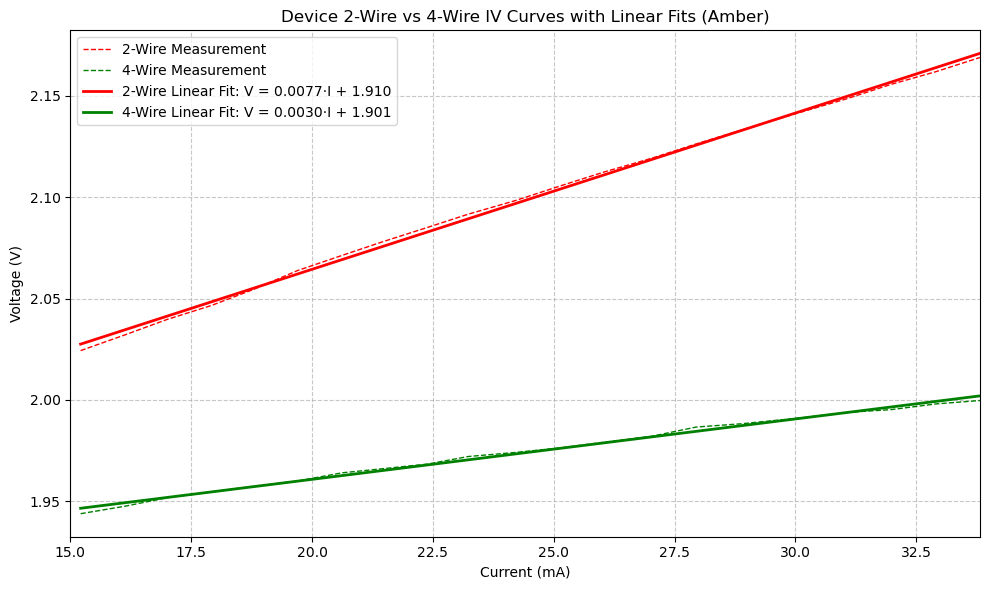

Characterization plot saved as 'Device_2_4_wire_Characterization_blue.png'


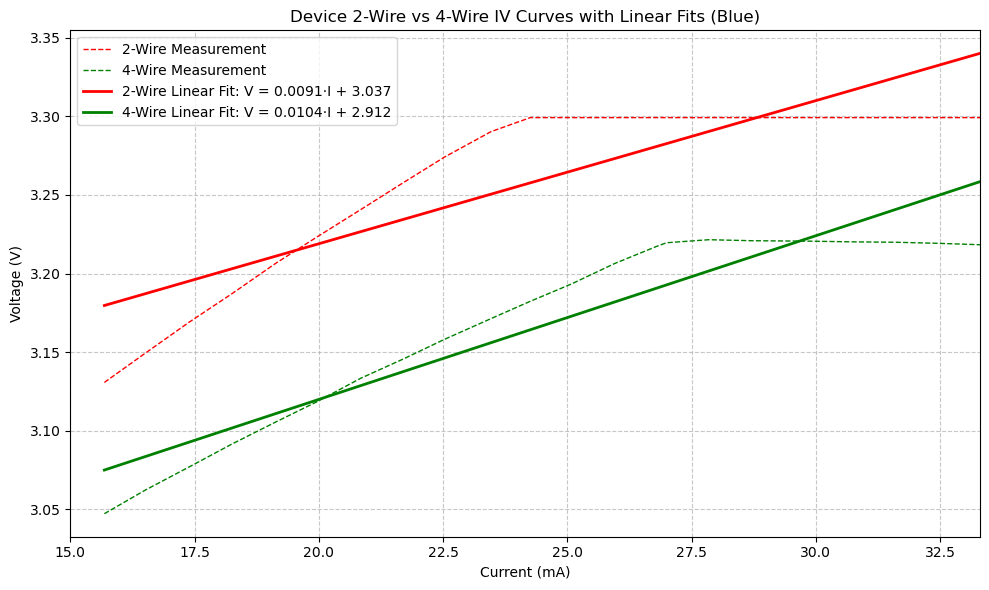

Characterization plot saved as 'Device_2_4_wire_Characterization_green.png'


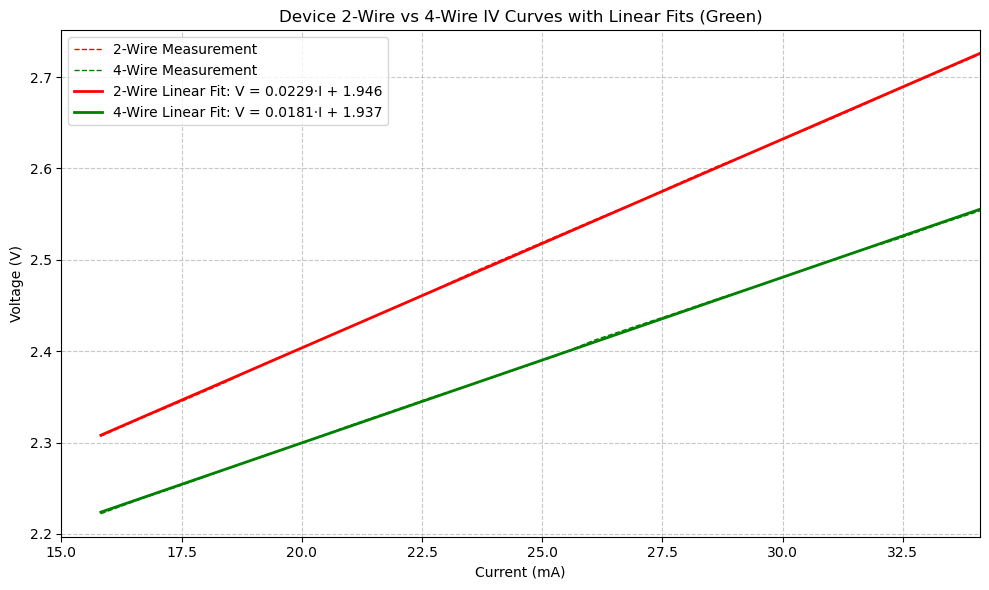

Characterization plot saved as 'Device_2_4_wire_Characterization_red.png'


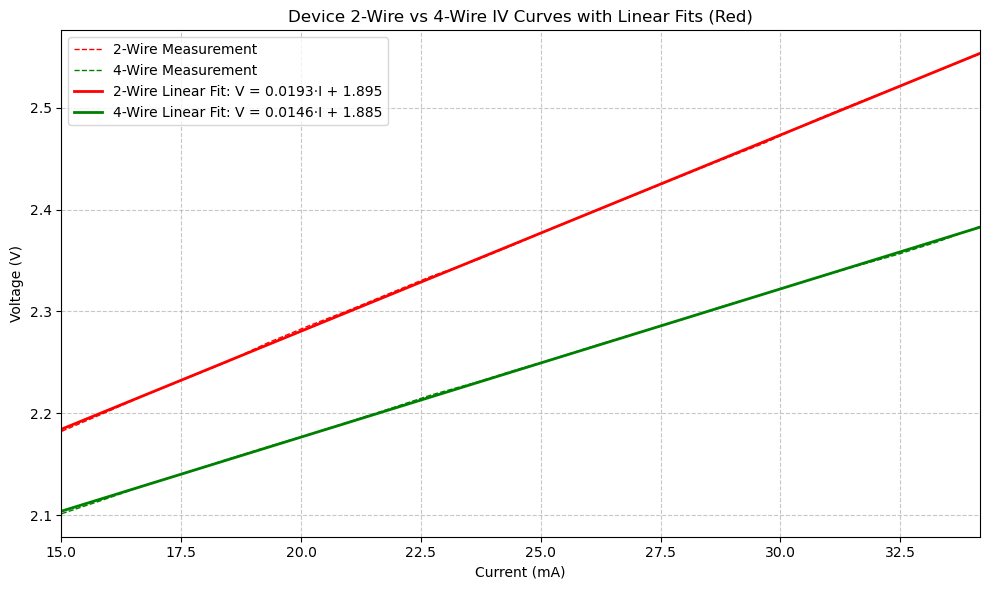

Characterization plot saved as 'Device_2_4_wire_Characterization_laser.png'


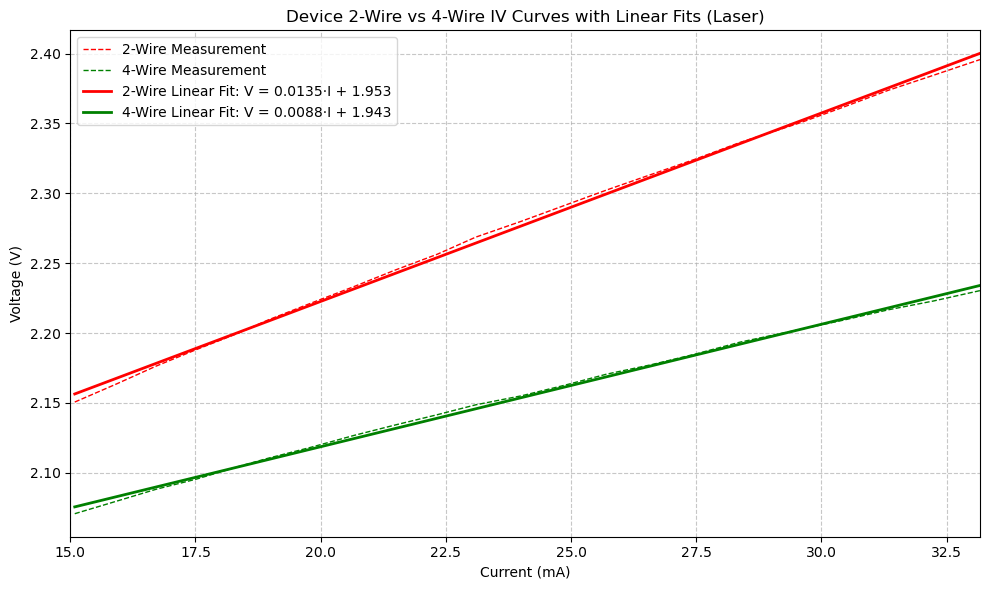

In [7]:

csv_files = {
    'amber': "Device_Characterization_Data_Amber26.7k_fr_current_power.csv",
    'blue': "Device_Characterization_Data_Blue26.7k_fr_current_power.csv",
    'green': "Device_Characterization_Data_Green26.7k_fr_current_power.csv",
    'red': "Device_Characterization_Data_Red26.7k_fr_current_power.csv",
    'laser': "Device_Characterization_Data_Laser26.7k_fr.csv"
}


for color, filepath in csv_files.items():
    df = pd.read_csv(filepath)
    
    # Filter data for current >= 15 mA
    df_valid = df[df["Current_mA"] >= 15].copy()
    
    if len(df_valid) > 0:
        
        
        plt.figure(figsize=(10, 6))
        plt.plot(df_valid["Current_mA"], df_valid["V_2wire"], 'r--', label='2-Wire Measurement', markersize=4, linewidth=1)
        plt.plot(df_valid["Current_mA"], df_valid["V_4wire"], 'g--', label='4-Wire Measurement', markersize=4, linewidth=1)

        # Linear fits for 2-wire and 4-wire
        x_fit = np.linspace(df_valid["Current_mA"].min(), df_valid["Current_mA"].max(), 100)

        fit_2, off_2 = np.polyfit(df_valid["Current_mA"], df_valid["V_2wire"], 1)
        plt.plot(x_fit, fit_2 * x_fit + off_2, 'r-', linewidth=2, label=f'2-Wire Linear Fit: V = {fit_2:.4f}·I + {off_2:.3f}')

        fit_4, off_4 = np.polyfit(df_valid["Current_mA"], df_valid["V_4wire"], 1)
        plt.plot(x_fit, fit_4 * x_fit + off_4, 'g-', linewidth=2, label=f'4-Wire Linear Fit: V = {fit_4:.4f}·I + {off_4:.3f}')


        plt.xlabel('Current (mA)')
        plt.ylabel('Voltage (V)')
        plt.xlim(15, df_valid["Current_mA"].max())
        plt.title(f'Device 2-Wire vs 4-Wire IV Curves with Linear Fits ({color.capitalize()})')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.legend()
        plt.tight_layout()

        resistance_plot_filename = f"Device_2_4_wire_Characterization_{color}.png"
        plt.savefig(resistance_plot_filename, dpi=300)
        print(f"Characterization plot saved as '{resistance_plot_filename}'")
        plt.show()


# wavelength and internal resistance #

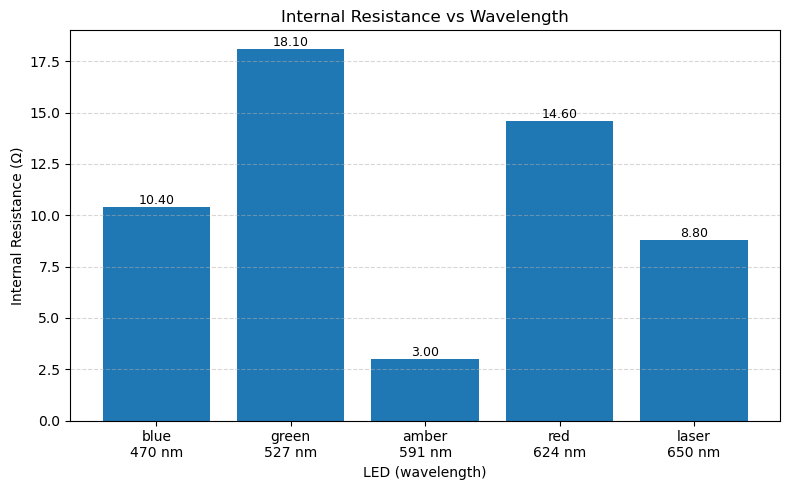

In [9]:
wavelengths = {
    'amber': 591,  # nm
    'blue': 470,   # nm
    'green': 527,  # nm
    'red': 624,    # nm
    'laser': 650   # nm
}

resistance = {
    'amber': 3.0,  # 𝞨
    'blue': 10.4,   # 𝞨
    'green': 18.1,  # 𝞨
    'red': 14.6,    # 𝞨
    'laser': 8.8   # 𝞨
}

# Bar plot: internal resistance for each wavelength
keys = [k for k in wavelengths.keys() if k in resistance]
# Sort by wavelength in increasing order
keys_sorted = sorted(keys, key=lambda k: wavelengths[k])
labels = [f"{k}\n{wavelengths[k]} nm" for k in keys_sorted]
vals = [resistance[k] for k in keys_sorted]

fig, ax = plt.subplots(figsize=(8,5))
bars = ax.bar(labels, vals, color='C0')
ax.set_xlabel('LED (wavelength)')
ax.set_ylabel('Internal Resistance (Ω)')
ax.set_title('Internal Resistance vs Wavelength')
ax.grid(axis='y', linestyle='--', alpha=0.5)

# Annotate bars with numeric values
for bar, val in zip(bars, vals):
    ax.text(bar.get_x() + bar.get_width()/2, val, f"{val:.2f}", ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig("Resistance_vs_Wavelength.png", dpi=300)
plt.show()

